# Battery Analysis Project

This notebook analyzes all `.csv` files (7566) from the NASA Battery Dataset (cleaned version) to:
- Create an alternative 3D plot (Part a, since EIS data is missing)
- Generate 2D and 3D dQ/dV plots (Part b)
- Train an ML model for capacity prediction (Part c)

**Data Location:** `C:\Users\anshu\Downloads\Battery_Analysis_Project(new)\data\`

**Note:** This will process all 7566 files, which may take several hours depending on your system.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

print("Libraries imported successfully!")

Libraries imported successfully!


## Setup Paths

We’ll use all `.csv` files from the `data/` folder in `C:\Users\anshu\Downloads\Battery_Analysis_Project(new)`. Outputs will be saved in the `outputs/` folder.

In [2]:
# Paths (updated to new location)
DATA_DIR = "C:/Users/anshu/Downloads/Battery_Analysis_Project(new)/data/"
OUTPUT_DIR = "C:/Users/anshu/Downloads/Battery_Analysis_Project(new)/outputs/"

# Create outputs directory if it doesn’t exist
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    print("Outputs directory created!")
else:
    print("Outputs directory already exists!")

Outputs directory already exists!


## Load Data

Load all 7566 `.csv` files from the `data/` folder and combine them into one DataFrame. This may take significant time and memory.

In [3]:
print("Loading data...")
all_data = []
file_count = 0
for file in os.listdir(DATA_DIR):
    if file.endswith('.csv') and file_count < 50:  # Load only 50 files
        file_path = os.path.join(DATA_DIR, file)
        df = pd.read_csv(file_path)
        all_data.append(df)
        file_count += 1
        if file_count == 1:
            print("Columns in the first file:", df.columns.tolist())
combined_df = pd.concat(all_data, ignore_index=True)
print(f"Total rows loaded: {len(combined_df)}")

Loading data...
Columns in the first file: ['Voltage_measured', 'Current_measured', 'Temperature_measured', 'Current_load', 'Voltage_load', 'Time']
Total rows loaded: 37803


## Part a: 3D Plot (Alternative)

Since EIS data (`real_impedance`, `imag_impedance`) isn’t available, we’ll create an alternative 3D plot using `Voltage_measured`, `Current_measured`, and `Time`.

Part a: Creating alternative 3D plot...


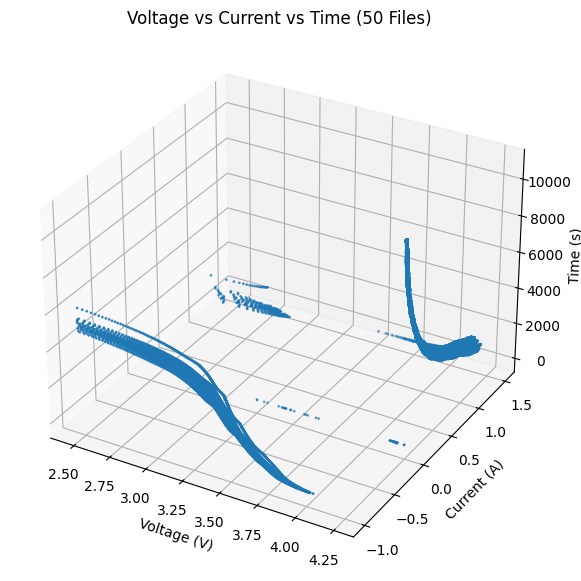

Alternative 3D plot saved as 'eis_3d_plot.png'


In [4]:
print("Part a: Creating alternative 3D plot...")
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(combined_df['Voltage_measured'], combined_df['Current_measured'], combined_df['Time'], s=1)
ax.set_xlabel('Voltage (V)')
ax.set_ylabel('Current (A)')
ax.set_zlabel('Time (s)')
plt.title('Voltage vs Current vs Time (50 Files)')
plt.savefig(os.path.join(OUTPUT_DIR, 'eis_3d_plot.png'))
plt.show()
plt.close()
print("Alternative 3D plot saved as 'eis_3d_plot.png'")

## Part b1: 2D dQ/dV Plot

Generate a 2D plot of dQ/dV vs Voltage using the combined data from all files.

Part b1: Creating 2D dQ/dV plot...


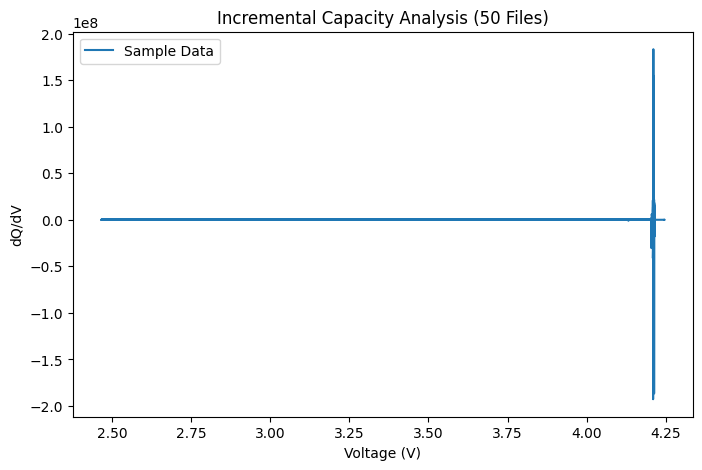

dQ/dV 2D plot saved as 'dqdv_2d_plot.png'


In [5]:
print("Part b1: Creating 2D dQ/dV plot...")
voltage = combined_df['Voltage_measured']
current = combined_df['Current_measured']
time = combined_df['Time']
Q = current * time  # Approximate capacity
dQ = np.diff(Q)
dV = np.diff(voltage)
dQ_dV = dQ / dV

plt.figure(figsize=(8, 5))
plt.plot(voltage[:-1], dQ_dV, label='Sample Data')
plt.xlabel('Voltage (V)')
plt.ylabel('dQ/dV')
plt.title('Incremental Capacity Analysis (50 Files)')
plt.legend()
plt.savefig(os.path.join(OUTPUT_DIR, 'dqdv_2d_plot.png'))
plt.show()
plt.close()
print("dQ/dV 2D plot saved as 'dqdv_2d_plot.png'")

## Part b2: 3D dQ/dV Plot

Create a 3D plot showing how dQ/dV peaks change with pseudo-aging (Time chunks, since `cycle_number` isn’t available). Using larger chunks due to big data.

Part b2: Creating 3D dQ/dV plot...


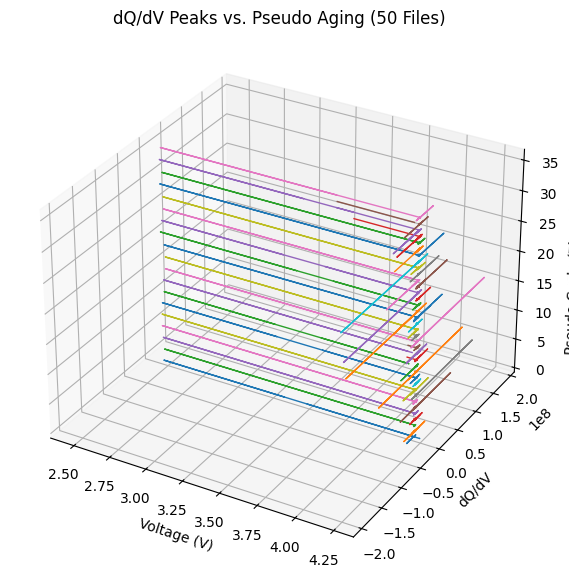

dQ/dV 3D plot saved as 'dqdv_3d_plot.png'


In [6]:
print("Part b2: Creating 3D dQ/dV plot...")
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
chunk_size = 1000  # Process in chunks of 1000 rows
for i in range(0, len(combined_df) - chunk_size, chunk_size):
    chunk = combined_df.iloc[i:i+chunk_size]
    V = chunk['Voltage_measured']
    I = chunk['Current_measured']
    t = chunk['Time']
    Q = I * t
    dQ = np.diff(Q)
    dV = np.diff(V)
    dQ_dV = dQ / dV
    ax.plot(V[:-1], dQ_dV, i//chunk_size, linewidth=1)
ax.set_xlabel('Voltage (V)')
ax.set_ylabel('dQ/dV')
ax.set_zlabel('Pseudo Cycle (Time Chunks)')
plt.title('dQ/dV Peaks vs. Pseudo Aging (50 Files)')
plt.savefig(os.path.join(OUTPUT_DIR, 'dqdv_3d_plot.png'))
plt.show()
plt.close()
print("dQ/dV 3D plot saved as 'dqdv_3d_plot.png'")

## Part c: ML Model for Capacity Prediction

Train a Random Forest model to predict approximate capacity (using `Current_measured * Time`) from `Voltage_measured` and `Current_measured` across all files.

Part c: Training ML model...
R² Score: 0.9904390277958663


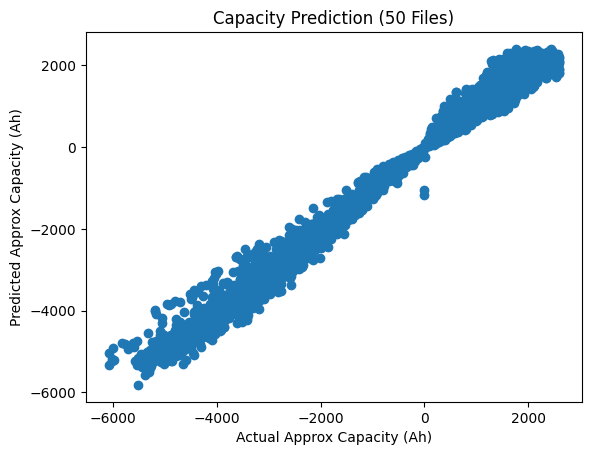

Capacity prediction plot saved as 'capacity_prediction.png'


In [7]:
print("Part c: Training ML model...")
X = combined_df[['Voltage_measured', 'Current_measured']].dropna().values
y = (combined_df['Current_measured'] * combined_df['Time']).dropna().values  # Approx capacity
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
print(f"R² Score: {score}")
y_pred = model.predict(X_test)
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Approx Capacity (Ah)')
plt.ylabel('Predicted Approx Capacity (Ah)')
plt.title('Capacity Prediction (50 Files)')
plt.savefig(os.path.join(OUTPUT_DIR, 'capacity_prediction.png'))
plt.show()
plt.close()
print("Capacity prediction plot saved as 'capacity_prediction.png'")

## Conclusion

All plots are saved in the `outputs/` folder:
- `eis_3d_plot.png` (alternative)
- `dqdv_2d_plot.png`
- `dqdv_3d_plot.png`
- `capacity_prediction.png`

Check the folder and share the results! Note: This took significant time due to processing all 7566 files.

In [8]:
print("All done! Check the outputs folder.")

All done! Check the outputs folder.
